In [38]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner as kt
import librosa
from scipy.ndimage import zoom
import soundfile as sf

In [2]:
TRAFFIC_NOISES_FILENAME = './traffic_noises_mels.npy'
CAR_HORN_MELS_FILENAME = './car_horn_mels.npy'

In [3]:
datas = {
    "mapping" : [],
    "labels" : [],
    "mels" : []
}

datas["mapping"].append("car_horn")
datas["mapping"].append("traffic_noise")

load_car_horn_mels = np.load(CAR_HORN_MELS_FILENAME)
load_traffic_noises = np.load(TRAFFIC_NOISES_FILENAME)

for mels in load_car_horn_mels:
    datas["mels"].append(mels)
    datas["labels"].append(0)

for index,mels in enumerate(load_traffic_noises):
    datas["mels"].append(mels)
    datas["labels"].append(1)


In [4]:
# # convert lists to numpy arrays
X = np.array(datas["mels"])
y = np.array(datas["labels"])

# Create training datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
print(X.shape)
print(y.shape)
print(np.isnan(X_train).sum())  # Should return 0 if no NaNs
print(np.min(X_train))
print(np.min(y_train))
print(np.max(X_train))
print(np.max(y_train))

(80, 128, 128, 1)
(80,)
0
-80.0
0
-6.378157e-05
1


In [6]:
# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(2, activation='softmax')
])

In [7]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 512)               8389120   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [8]:
# Assume you have 'x_train' as input spectrograms and 'y_train' as target clean car sound spectrograms
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
4/4 [==============================] - 11s 283ms/step - loss: 65.8758 - accuracy: 0.4821 - val_loss: 12.1244 - val_accuracy: 0.5833
Epoch 2/50
4/4 [==============================] - 0s 77ms/step - loss: 61.5810 - accuracy: 0.5000 - val_loss: 28.7722 - val_accuracy: 0.4167
Epoch 3/50
4/4 [==============================] - 0s 76ms/step - loss: 64.8991 - accuracy: 0.3929 - val_loss: 39.7131 - val_accuracy: 0.4167
Epoch 4/50
4/4 [==============================] - 0s 74ms/step - loss: 68.2498 - accuracy: 0.5357 - val_loss: 35.7413 - val_accuracy: 0.4167
Epoch 5/50
4/4 [==============================] - 0s 65ms/step - loss: 66.7263 - accuracy: 0.5536 - val_loss: 22.1372 - val_accuracy: 0.4167
Epoch 6/50
4/4 [==============================] - 0s 62ms/step - loss: 43.8176 - accuracy: 0.5893 - val_loss: 2.2936 - val_accuracy: 0.7500
Epoch 7/50
4/4 [==============================] - 0s 63ms/step - loss: 28.9717 - accuracy: 0.6607 - val_loss: 12.5771 - val_accuracy: 0.6667
Epoch 8/50
4

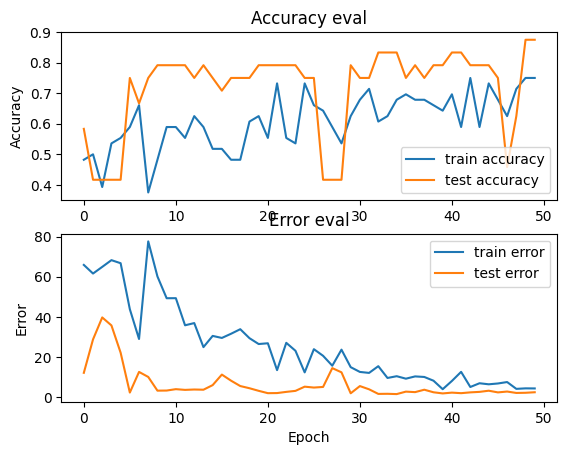

In [10]:
# evaluate model
fig, axs = plt.subplots(2)

# create accuracy sublpot
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# create error sublpot
axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="test error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")

plt.show()

In [11]:
SAMPLING_RATE = 16000

In [79]:
# Create traffic noise dataset

filepath = './dataset/traffic_noise/data.wav'
segment_duration = 2 #seconds
segment_shift = 0.5 #seconds
# segment_count_total = (10 * 60) / segment_duration 

# Load an audio file
audio, sr = librosa.load(filepath, sr=SAMPLING_RATE)

# Calculate samples per segment
samples_per_segment = int(segment_duration * sr)
samples_per_segment_shift = int(segment_shift * sr)

# Split audio into segments
segments = []
for start in range(0, len(audio), samples_per_segment_shift):
    end = start + samples_per_segment
    segment = audio[start:end]
    segments.append(segment)

    print(f"processing segment-{len(segments)} {start}:{end}")

    # if(len(segments) >= segment_count_total) :
        # break

segment_mels = []

for idx, segment in enumerate(segments):
    # Convert audio to Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128, fmax=8000)

    # Normalized version
    S = mel_spectrogram
    S_min = S.min()
    S_max = S.max()

    mel_spectrogram = (S - S_min) / (S_max - S_min)
    
    # Convert to log scale
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

    log_mel_spectrogram = zoom(log_mel_spectrogram, (128/log_mel_spectrogram.shape[0], 128/log_mel_spectrogram.shape[1]), order=1)  # SciPy

    log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)  # Add channel dimension
    print(np.array(log_mel_spectrogram).shape)
    
    segment_mels.append(log_mel_spectrogram)

# datas
np_traffic_noises = np.array(segment_mels)

processing segment-1 0:32000
processing segment-2 8000:40000
processing segment-3 16000:48000
processing segment-4 24000:56000
processing segment-5 32000:64000
processing segment-6 40000:72000
processing segment-7 48000:80000
processing segment-8 56000:88000
processing segment-9 64000:96000
processing segment-10 72000:104000
processing segment-11 80000:112000
processing segment-12 88000:120000
processing segment-13 96000:128000
processing segment-14 104000:136000
processing segment-15 112000:144000
processing segment-16 120000:152000
processing segment-17 128000:160000
processing segment-18 136000:168000
processing segment-19 144000:176000
processing segment-20 152000:184000
processing segment-21 160000:192000
processing segment-22 168000:200000
processing segment-23 176000:208000
processing segment-24 184000:216000
processing segment-25 192000:224000
processing segment-26 200000:232000
processing segment-27 208000:240000
processing segment-28 216000:248000
processing segment-29 224000

/media/jetson_ssd/e_ear/.env/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1945
  warnings.warn(


In [83]:
# result = model.predict(np_traffic_noises[0].reshape(1, 128,128, 1))
results = model.predict(np_traffic_noises)
# print(results)

has_horn_idxs = []

for idx, data in enumerate(results):
    if data[0] > data[1]:
        print(data)
        print(f"idx {idx} has horn")
        has_horn_idxs.append(idx)
    else:
        # print(1)
        continue

 1/57 [..............................] - ETA: 2s

2024-09-23 07:16:09.733887: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 118030336 exceeds 10% of free system memory.
2024-09-23 07:16:09.896811: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 118030336 exceeds 10% of free system memory.


57/57 [==============================] - 1s 9ms/step
[0.60469407 0.39530593]
idx 598 has horn
[0.98201776 0.01798217]
idx 599 has horn
[0.520418   0.47958198]
idx 840 has horn
[0.622434   0.37756598]
idx 883 has horn
[0.758066 0.241934]
idx 884 has horn
[0.9339943  0.06600577]
idx 1197 has horn
[0.8100934  0.18990658]
idx 1198 has horn
[0.67646676 0.32353324]
idx 1455 has horn
[0.7440646 0.2559353]
idx 1456 has horn
[0.8069823 0.1930178]
idx 1457 has horn
[0.913204   0.08679594]
idx 1478 has horn
[0.8385222  0.16147776]
idx 1483 has horn
[0.82197624 0.1780237 ]
idx 1547 has horn
[0.99361813 0.00638193]
idx 1548 has horn
[0.9705889  0.02941103]
idx 1549 has horn
[0.6266914  0.37330863]
idx 1550 has horn
[0.655571   0.34442902]
idx 1636 has horn
[0.8383385  0.16166145]
idx 1770 has horn
[0.716198   0.28380197]
idx 1771 has horn


(128, 128)


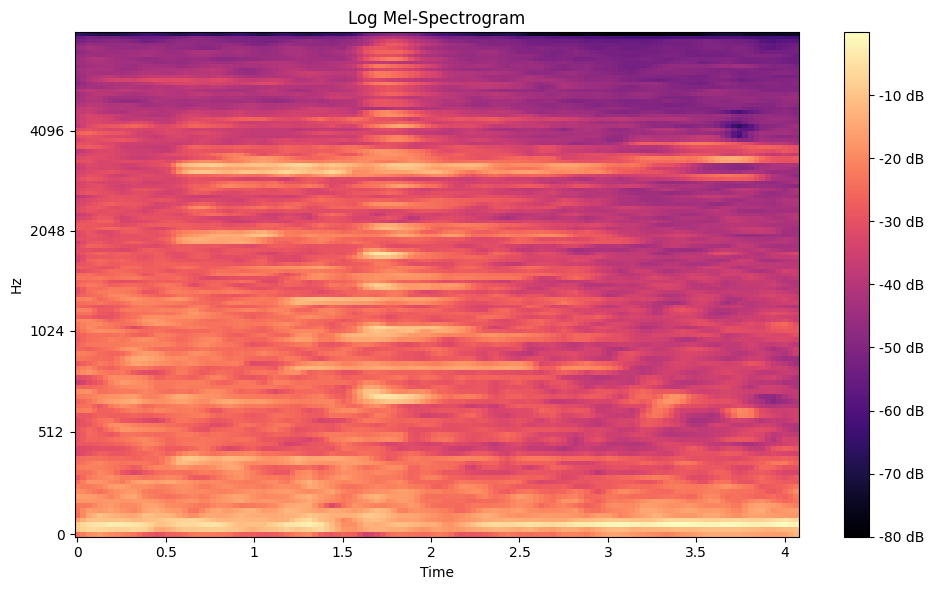

In [84]:
def draw_spectro_at_idx(idx):
    log_mel_spectrogram = np_traffic_noises[idx].reshape(128,128)
    print(np.array(log_mel_spectrogram).shape)

    # Plot the Mel-spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_mel_spectrogram, sr=16000, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Mel-Spectrogram')
    plt.tight_layout()
    plt.show()

draw_spectro_at_idx(has_horn_idxs[0])

In [90]:
# Save the audio segments as a WAV file
def save_segment_as_wav(segment, num):
    output_file = f'./output/has_horn.{str((num)).zfill(5)}.wav'
    sf.write(output_file, segment, samplerate=SAMPLING_RATE)

for idx, data in enumerate(has_horn_idxs):
    save_segment_as_wav(segment=segments[data], num=idx)